# I - Qu'est-ce qu'une trajectoire ? 
Dans les deux notebooks "service_use.ipynb" et "client_creation", on a vu comment créer un client et comment lancer le service de l'optimisation pour créer une trajectoire concernant ce client. En particulier, on a vu comment générer une trajectoire optimisée, une trajectoire standard (chauffe-eau seul) ainsi qu'une trajectoire Routeur seul. 

Dans ce Notebook, on verra comment manipuler une trajectoire. Dans ce projet, une trajectoire est un objet complexe qui contient énormément d'informations : Les décisions appliqués au chauffe-eau, les températures, les échanges électriques et aussi l'environnement (contexte et configurations ...). Autrement dit, elle contient les informations sur l'évolution du système domestique entre un point temporel $t_A$ et $t_B$. 

La classe implémentée pour le type des trajectoires est **TrajectorySystem**. La création d'une trajectoire en utilisant cette classe (par instanciation) est relativement complexe (elle sera détaillée dans la dernière section). L'usage général de ce moteur d'optimisation consiste à travailler avec des trajectoires générées par le service. 

Le code suivant sert uniquement à reprendre les deux anciennes parties pour créer une trajectoire exemplaire sur laquelle on va travailler. 

In [1]:
from pathlib import Path 
from optimiser_engine import Client, OptimizerService 
import pandas as pd 
BASE_DIR = Path.cwd()
data_path = BASE_DIR / "weather.csv" 
client_file = BASE_DIR / "client_sample.yaml" 

client = Client.from_yaml_file(client_file) 
df_solar = pd.read_csv(data_path, parse_dates=["date"]).set_index("date")


service = OptimizerService() 

from datetime import datetime 

trajectoire = service.trajectory_of_client(client, datetime(2026,1,1,1,0), 55, df_solar) 

/Users/anaselb/Dev/libs_optimasol/optimiser_engine_v2.0/src/optimiser_engine/engine/service.py:384: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  target_index = pd.date_range(


Dans ce Notebook, on verra : 
- L'environnement d'une trajectoire (Fait partie de l'objet. Principalement les configurations systèmes domestiques et le contexte externe de la trajectoire) 
- L'accès aux décisions, températures, exportations et importations (de puissance électrique). 
- L'accès aux indicateurs de performances d'une trajectoire (coût et autoconsommation).
- La modification d'une trajectoire. 

# II - L'environnement 
L'environnement d'une trajectoire représente l'ensemble des paramètres domestiques durant l'intervalle de la trajectoire. Comme dit avant, une trajectoire décrit l'évolution du système domestique entre deux instants $t_A$ et $t_B$. L'environnement englobe des paramètres diverses de la situation entre ces deux instants. Par exemple, le volume du cumulus, la production solaire, la consommation de la maison... font partie de l'environnement de la trajectoire. Ces paramètres de l'environnement sont répartis en deux types, les configurations système et le contexte externe. Dans cette section, nous détaillons comment accéder à ces paramètres pour une trajectoire donnée. 

## 1 - Les configurations système :
Il est possible d'accéder aux configurations via l'attribut *config_system*. Voici les configurations qu'on peut tirer d'un tel objet : 

| **Paramètre** | **Attribut** | **Type** | **Description** | 
| :--- | :--- | :--- | :--- |
| Puissance | *power* | Nombre (int ou float) | La puissance nominale du chauffe-eau | 
| Volume | *volume* | Nombre (int ou float) | Volume du chauffe-eau | 
| Température froide | *T_cold_water* | Nombre (int ou float) | La température de l'eau froide | 
| Température minimale | *T_min_safe* | Nombre (int ou float) | Température minimale de sécurité | 
| Température maximale | *T_max_safe* | Nombre (int ou float) | Température maximale de sécurité | 
| Coefficient de Pertes | *heat_loss_coefficient* | Nombre (int ou float) | Pertes de températures en (°C/min) | 
| Gradation | *is_gradation* | Booléen | Mode gradation de puissance (activé ou non) |

Voici comment accéder à l'objet "configuration Système", c'est un objet de type **SysConfig**. 

In [2]:
# On accède à l'objet config_system :
configuration_systeme = trajectoire.config_system 

Voici comment accéder à chaque attribut de la configuration système : 

In [3]:
puissance = configuration_systeme.power 
volume = configuration_systeme.volume
temperature_froide = configuration_systeme.T_cold_water 
temperature_minimale = configuration_systeme.T_min_safe 
temperature_maximale = configuration_systeme.T_max_safe 
pertes = configuration_systeme.heat_loss_coefficient
gradation = configuration_systeme.is_gradation 
# On les affiche (exemple) :
print("Puissance :", puissance) 
print("Volume :", volume)
print("Température froide :", temperature_froide)
print("Température minimale :", temperature_minimale)
print("Température maximale :", temperature_maximale)
print("Pertes thermiques :", pertes)
print("Gradation :", gradation)

Puissance : 2500.0
Volume : 200.0
Température froide : 10.0
Température minimale : 40.0
Température maximale : 95
Pertes thermiques : 0
Gradation : True


> **NOTE** : Évidemment, il est possible d'accéder à ces paramètres via le client aussi. (Sauf pour la température minimale / maximale, qui est une variable de classe). Mais parfois, il est plus pratique d'accéder à ceux-ci depuis la trajectoire. Ceci s'applique encore plus pour le contexte, qui est l'objet de la sous-section suivante. 

## 2 - Le contexte : 
On a vu dans la section précédente, les configurations systèmes. Cela repésente les paramètres statiques du système domestique (un peu indépendants de la trajectoire). Or, pour une trajectoire, il y a aussi des paramètres qui dépendent de la trajectoire, la date de la trajectoire par exemple, la production solaire... Ce sont les paramètres qui rentreront dans le contexte. 

À l'intérieur de ce contexte, il y a des paramètres scalaires (la date de la trajectoire par exemple), mais aussi des paramètres "signaux temporels", par exemple la production solaire ou bien les exigences de consignes sont des fonctions $P_{solaire}(t)$ ou $f_{consigne}(t)$ définies sur l'intervalle $[t_A, t_B]$. 

Dans ce contexte, ces paramètres "séries temporels" seront stockés par des vecteurs. Comme l'intervalle de la trajectoire est fixe $[t_A, t_B]$, tout ces vecteurs auront la même taille $N$. On définit également un pas de temps $p$, pour tout vecteur $X$ (attribut du contexte), la quantité $X[i]$ est la quantité de $X$ à l'instant $t_A + i \times p$. Il est aussi clair de voir que $t_B - t_A$ (representant l'horizon), est la durée égale à $p \times N$. 

Pour accéder à l'objet "context", cela s'effectue via l'attribut *context*. Voici un exemple : 

In [4]:
contexte = trajectoire.context

### 2a - Les scalaires du contextes :

Comme expliqué avant, un paramètre scalaire est un paramètre qui possède une valeur unique et fixe pour l'ensemble d'une trajectoire donnée. Il définit une caractéristique globale de l'expérience, comme la date d'exécution ou une condition initiale, sans varier au cours du temps.

Voici les éléments scalaires du contexte, accessible comme attributs du contexte : 
| Paramètre | Attribut | Type | Description | 
|----------|---------|----------|----------| 
| Nombre de points $N$ | *.N* | entier (int) | Nombre de points dans les séries temporelles | 
| Pas de temps | *.step_minutes* | entier (int) | Nombres de minutes dans le pas de temps des séries temporelles | 
| Référence de temps | *.reference_datetime* | format datetime | L'instant initial de la trajectoire ($t_A$) | 

Voici un exemple de code pour extraire ces attributs de la trajectoire : 

In [5]:
N = contexte.N 
pas_temps = contexte.step_minutes 
reference_temps = contexte.reference_datetime 
# Affichage (exemple) : 
print("Nombre de pas de temps :", N)
print("Pas de temps (minutes) :", pas_temps)
print("Référence temporelle :", reference_temps)

Nombre de pas de temps : 96
Pas de temps (minutes) : 15
Référence temporelle : 2026-01-01 01:00:00


> **NOTE** :
> 
> - L'entier $N$ est très important, c'est le nombre des éléments dans les vecteurs qui vont être tracés par la suite.
> - Les données précédentes sont, pour une trajectoire générée par le service, les entrées du service d'optimisation. Mais en pratique il est plus simple pour les visualisations de les tirer de cet endroit.


### 2b - Les séries temporelles : 
Une série temporelle est un paramètre dont la valeur évolue au cours du temps le long de la trajectoire, représentée sous la forme d'un vecteur de données échantillonnées. Elle permet de modéliser des flux dynamiques, tels que la production solaire ou les consignes de température, associés à un pas de temps régulier.

#### Les différentes séries :

Voici un résumé des séries temporels qu'on peut tirer de l'objet *context* : 
| **Série temporelle** | **Attribut** | **Description** |
|----------------------|--------------|-----------------| 
| Possibilité de chauffe | *.availability_on* | Les éléments internes sont 0 ou 1 représentant la possibilité de chauffe à cet instant | 
| Consignes futures | *.future_setpoints*| Les éléments sont les températures de consignes à chaque instant. (*Si pas de consigne, on met la température minimale de confort*) | 
| Consommation domestique | *.house_consumption* | Représente la consommation de tout les appareils à part le chauffe-eau. | 
| Heures creuses | *.off_peak_hours* | Les éléments internes sont 0 ou 1 selon si on est en heures creuses ou pas | 
| Prix d'achat | *.prices_purchases* | Représente le prix d'achat à l'instant concerné | 
| Prix de revente | *.prices_sell* | Représente le prix de revente à l'instant concerné (*Généralement constant*) | 
| Production solaire | *.solar_production* | Représente la puissance solaire à cet instant (en Watts) | 
| Tirages d'eau | *.water_draws* | Représente la quantité d'eau tirée à cet instant (peut être nulle) | 

> **NOTE** : 
> 
> - Tout ces vecteurs sont de type `np.ndarray`. Leur dimension est `(N,)` 
> - Pour le prix de revente, la création du client impose un prix constant, pour l'évolutivité du projet, ici on considère un vecteur, éventuellement rempli par la même valeur de revente. 
> - Il est toujours possible de tirer ces données depuis le client (dans le cas d'une trajectoire générée par le service d'optimisation). Mais pour les visualisations (courbes...), les reprendre de cet endroit est plus efficace. 

Voici un exemple de code qui tire ces paramètres : 

In [6]:
possibilite_chauffe = contexte._availability_on 
consignes_futures = contexte.future_setpoints
consommation_maison = contexte.house_consumption 
heures_creuses = contexte.off_peak_hours 
prix_achat = contexte.prices_purchases 
prix_revente = contexte.prices_sell 
production_solaire = contexte.solar_production 
tirage_eau = contexte.water_draws 

Voici la dimension de ces arrays, (exemple) :

In [7]:
import numpy as np
print(np.shape(possibilite_chauffe)) 

(96,)


#### Exemple de visualisation : 
L'avantage majeur de la vectorisation de ces séries temporels les rendent faciles à visualiser pour une trajectoire. Par exemple en disposant d'une tajectoire, on peut facilement accéder à la production solaire durant cette trajectoire... 

Ci-dessous on donne un exemple de visualisation de la production solaire et la consommation domestique. Il est possible de visualiser les autres de la même manière. 

In [8]:
# On crée le vecteur des abcisses qui correspond aux temps : 
step = np.timedelta64(pas_temps, "m")  
t0 = np.datetime64(reference_temps)  
x = t0 + np.arange(N) * step 

In [9]:
import matplotlib.pyplot as plt 

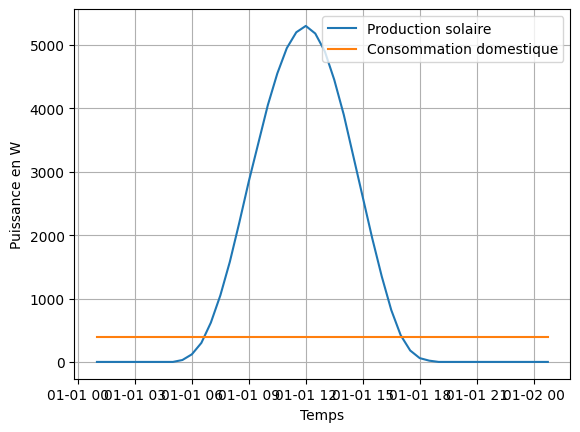

In [10]:
plt.plot(x,production_solaire, label="Production solaire") 
plt.plot(x, consommation_maison, label="Consommation domestique")
plt.xlabel("Temps") 
plt.ylabel("Puissance en W") 
plt.legend()
plt.grid(True)
plt.show()

# III - Décisions et Conséquences 

Dans la section précédente, on a vu les paramètres environnementales d'une trajectoire. Puisque la trajectoire décrit l'évolution du système domestique entre deux points temporels (en particulier l'évolution du chauffe-eau), celle-ci comporte l'information sur l'évolution de la puissance du chauffe-eau, la température dans le chauffe-eau, ainsi que les échanges électriques avec le réseau. 

En fait, dans l'application concrète du moteur d'optimisation, le but est de calculer la trajectoire optimisée pour appliquer la première décision (Principe de l'horizon glissant). 

Dans cette section, nous verrons comment accéder aux : 
- Décisions
- Températures 
- Exportations (électriques) 
- Importations (électriques) 

## 1 - Décisions :
Pendant l'intervalle de la trajectoire, la puissance du chauffe-eau $P(t)$ est variable. On appelera décision à l'instant $t$, nôtée $x(t)$ la quantité $P(t)/P_{nominale}$. Cette quantité varie de 0 (chauffe-eau éteint) à 1 (chauffe-eau allumé au fond). 

On peut accéder aux décisions prises durant une trajectoire via la méthode `get_decisions()`. Celle-ci génère un vecteur de type `np.ndarray` de dimension `(N,)` où N est le nombre de points définis dans le contexte. 

Voici un exemple de code qui tire les décisions de la trajectoire : 

In [11]:
decisions = trajectoire.get_decisions() 

On peut visualiser ces décisions de la même manière que précédemment, voici un exemple :

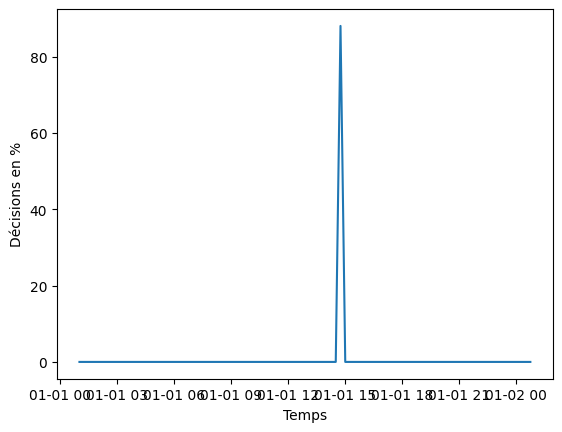

In [12]:
plt.plot(x, 100*decisions, label="Décisions appliqués") 
plt.xlabel("Temps") 
plt.ylabel("Décisions en %") 
plt.show()

## 2 - Températures : 
Durant une trajectoire, la température dans le chauffe eau est variable aussi et suit un profil $T(t)$. Il est possible de tirer les températures de la trajectoire via la méthode `get_temperatures()`. Celle-ci génère un vecteur de type `np.ndarray`. Sa dimension est `(N+1,)` avec $N$ la dimension définie dans le contexte. 

Voici un exemple d'extraction du vecteur de la température : 


In [13]:
temperatures = trajectoire.get_temperatures() 

> **NOTE** : Contrairement aux décisions, les températures ont une dimension `(N+1,)`, ceci vient du fait que ce vecteur contient aussi l'information de la température initiale. Contrairement à la décision (on applique une décision pendant un intervalle temporel), la température est une notion ponctuelle, d'où la nécessité de $N+1$ points. 

Il est par ailleurs possible d'accéder à la température initiale via l'attribut `initial_temperature`

In [14]:
temperature_initiale = trajectoire.initial_temperature 
print(temperature_initiale)

55


## 3 - Importations : 
Il s'agit da la puissance qui rentre depuis le réseau. Elle est accessible via la méthode `get_imports`, celle-ci génère, comme les décisions, un vecteur `np.ndarray` de taille `(N,)`. 

Voici un exemple de code pour extraire les importations : 

In [15]:
importations = trajectoire.get_imports() 

## 4 - Exportations : 
Il s'agit da la puissance qui sort vers le réseau. Elle est accessible via la méthode `get_exports`, celle-ci génère, comme les décisions, un vecteur `np.ndarray` de taille `(N,)`. 

Voici un exemple de code pour extraire les exportations : 

In [16]:
exportations = trajectoire.get_exports() 

Voici un exemple de code qui visualise l'évolution des importations et des exportations : 

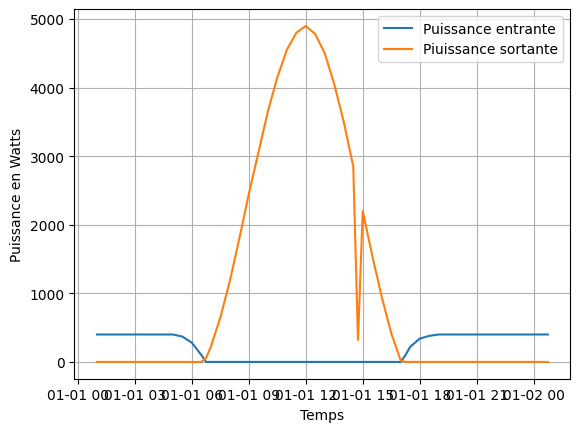

In [17]:
plt.plot(x,importations, label="Puissance entrante") 
plt.plot(x,exportations, label="Piuissance sortante") 

plt.xlabel("Temps") 
plt.ylabel("Puissance en Watts") 
plt.grid(True) 
plt.legend()
plt.show() 

> **NOTE** : On voit dans le diagramme, que la puissance entrante s'annule quand la puissance sortante est non nul et vice versa. Cela vient d'une équation $E \times I = 0$ . Car, pour une trajectoire optimisée (ce qui est notre cas), il est inutile de vendre et acheter en même temps lorsque le tarif de revente est plus bas que le tarif d'achat. 

# IV - Indicateurs de performances 

Dans la dernière section, on a vu comment tirer les paramètres de décisions et ses conséquences (températures, échanges électriques...). 
Dans cette section, nous verrons comment accéder aux KPIs d'une trajectoire. Les indicateurs que nous allons rencontrer sont : 
- Le **coût** d'une trajectoire. 
- L'**autoconsommation** réalisée par une trajectoire. 

## 1 - Coût :
Le coût d'une trajectoire représente la quantité d'argent payée pour réaliser la trajectoire. Le calcul repose sur les exportations / importations d'une part et les prix de ventes / achat dans le contexte d'une autre part. 

Pour accéder au coût, on utilise la méthode `compute_cost()`. Voici un exemple :


In [18]:
cout = trajectoire.compute_cost() 
print(cout)

-1.8139342105263163


> **NOTE** :
> - Le coût peut être négatif, c'est le cas où on gagne l'argent. Dans la vraie vie, ce cas est très rare, mais lorsque la production solaire est très élevée par rapport à la consommation, ce cas peut arriver. 
> - L'unité du coût est imposée par le prix au KWh dans le contexte et indirectement dans le client. Autrement dit, si vous définissez un prix au KWh en euros, vous aurez un coût en euros. Si vous le définissez en centimes, vous l'aurez en centimes... Ce qui est le plus important, c'est que le prix dans le contexte (et dans le client) doit être par rapport à 1KWh. 
> - Il est normal d'avoir un coût très élevé quand le mode de l'optimisation choisi est "Autoconsommation". Dans ce cas, le solveur d'optimisation va générer une trajectoire qui maximise l'autoconsommation peu importe le coût de ça. Il faut donc garder à l'esprit que coût ≠ autoncommation. 

## 2 - Autoconsommation :
Durant une trajectoire, il y a un échange électrique avec le réseau et en même temps une production solaire. L'autonconsomation d'une trajectoire représente combien d'énergie solaire a été réellement consommée par rapport à cette même production. 

Autrement dit, sa formule est : $\frac{\text{Production solaire} - \text{Exportations}}{\text{Production solaire}}$ 

Cette quantité est accessible via la méthode : `get_self_autoconsumption`. 

Voici un exemple : 

In [19]:
autoconsommation = trajectoire.compute_self_consumption() 
# En pourcentage : 
autoconsommation = 100*autoconsommation 
print(f"L'autoconsommation vaut {autoconsommation} %")

L'autoconsommation vaut 15.676283161600612 %


> **NOTE** :
> - L'autoconsommation générée par la méthode `get_self_autoconsumption` est un nombre entre 0 et 1, pour l'avoir en pourcentage, il faut multiplier par $100$. 
> - Dans le cas de consommation faible par rapport à la production solaire, il est possible de ne jamais avoir une autoconsommation de $100%$. Ce n'est pas alors une question d'optimisation, juste mathématiquement c'est impossible. 
> - Comme pour le coût, il est naturel d'avoir parfois une autoconsommation faible quand le mode d'optimisation est `COST`. Car ce mode fait que le solveur essaie d'optimiser économiquement et ne s'intéresse pas à l'autoconsommation. 

# V - Avancé : Modification ou création d'une trajectoire

Dans les sections précédentes, on a vu comment manipuler une trajectoire, comment en tirer l'environnement, les décisions, les conséquences, calculer les indicateurs de performances... 

La trajectoire manipulée est généré par le service d'optimisation. Or, comme évoqué dans le Notebook "service_use.ipynb", le service peut générer trois trajectoires seulement : 
- Une trajectoire optimisée. 
- Une trajectoire standard d'un chauffe eau sans routeur. 
- Une trajectoire du routeur sans optimisation. 
Mais en général, ces trajectoires concernent un horizon et sont destinés à l'application principale de ce moteur d'optimisation (Envoyer la première décision de la trajectoire conformément au principe de l'horizon glissant). 

Dans cette section, nous intéressons à la modification d'une trajectoire et la création d'une nouvelle trajectoire en dehors du service d'optimisation. 

Le but de la modification est de pouvoir répondre à ce genre de questions : "Et si je chauffe comme ça, quelle serait le coût?", la modification d'une trajectoire offre la possibilité de changer les décisions appliqués à un chauffe eau pendant la trajectoire et de voir comment cela s'implique pour les autres éléments de la trajectoire (températures, échanges électriques, KPIs...). 

La deuxième partie de cette section (Création d'une trajectoire en dehors du service), permet d'offrir la possibilité de création de trajectoires un peu inhabituelles qui sortent du cadre de l'horizon glissant et l'application directe. Parce que l'architecture de la trajectoire offre la possibilité de modéliser n'importe quelle évolution. (Exemple : L'évolution du chauffe eau sur plusieurs mois / années peut être simplement modélisée par une trajectoire avec un contexte long(le N assez grand)). 

## 1 - Modification d'une trajectoire :

Comme évoqué dans les premières sections, une trajectoire contient : 
- Un environnement (configurations, contexte et une température initiale). 
- Des décisions. 

Ces deux éléments ont des conséquences (Températures, échanges, KPIs...). 

Il est possible de changer l'environnement ou bien les décisions. 

### 1a - Modification des configurations systèmes :

La modification se fait via l'accès aux attributs des configurations systèmes (tout comme attributs en Python). Les attributs sont détaillés dans la section II. Voici un exemple qui modifie le volume et la puissance du chauffe eau. 

In [20]:
trajectoire.config_system.power = 3000 
trajectoire.config_system.volume = 400 

print(trajectoire.config_system.power) 
print(trajectoire.config_system.volume)

3000
400


### 1b - Modification de la température initiale : 
Cela s'effectue simplement via l'accès à l'attribut `initial_temperature`, voici un exemple : 

In [21]:
trajectoire.initial_temperature = 40

### 1c - Modification du contexte : 
C'est la modification la plus critique. Les attributs du contexte sont détaillés dans la section II. 
La variable `context` contient une référence de dates, un pas de temps, une **dimension** et des vecteurs de cette dimension. 

Ce qu'il faut savoir, c'est que le changement de la dimension entraîne automatiquement la suppression de tout les vecteurs du contexte. (Car dans un contexte, les vecteurs doivent respecter strictement la dimension imposée par $N$.) A ce moment là, il faut réintroduire les vecteurs de la dimension `(N,)` dans l'attribut `context`de la trajectoire. 


Pour modifier un vecteur, il faut simplement respecter la dimension existante, sinon cela génère `DimensionNotRespected`. 

Le modification de la référence de dates, ou bien du pas se font de manière fluide tant que vous mettez des valeurs réalistes du bon type. 

### 1d - Modification des décisions : 
La modification des décisions est possible en accédant à l'attribut `.x` de la trajectoire : 

In [22]:
trajectoire.x 

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.88105263, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

> **NOTE** : Le vecteur remis doit être de taille $N$ (le même N défini dans le contexte), les valeurs prises par x doivent être comprises entre 0 et 1. Si l'une de ces conditions n'est pas respectés, cela lève des erreurs. 


Par exemple, voici un code qui remet dans les décisions un vecteur (généré aléatoirement par numpy) :

In [23]:
x = np.random.rand(N)  
trajectoire.x = x 
trajectoire.update_X() 
print(trajectoire.get_decisions())


[0.24383087 0.08458555 0.14716221 0.29821072 0.89058622 0.21270278
 0.39343199 0.27523794 0.41279351 0.37725817 0.96542285 0.76425138
 0.71025891 0.84428182 0.60620312 0.05864142 0.88674928 0.04853079
 0.17999275 0.59164395 0.6581405  0.06513929 0.22476543 0.04612025
 0.34040334 0.52580361 0.91994506 0.52322282 0.59461253 0.205111
 0.85418909 0.45547671 0.69490806 0.00620618 0.32435945 0.09726038
 0.66786    0.67251066 0.40185727 0.40413394 0.81269137 0.17992912
 0.64017567 0.20960665 0.8058101  0.03717401 0.56189858 0.11670997
 0.14324294 0.57520357 0.44600233 0.44732302 0.10635778 0.05581338
 0.36174084 0.04094412 0.16612329 0.25905406 0.55829377 0.69315287
 0.80312214 0.10209861 0.6608275  0.70326896 0.07717036 0.59407607
 0.26919503 0.22691891 0.08756676 0.60707412 0.05649925 0.33103067
 0.54492155 0.86775516 0.88385809 0.40741808 0.1111027  0.41313607
 0.04577037 0.46825267 0.14968283 0.56706719 0.91463784 0.59241516
 0.39194324 0.55638664 0.10078318 0.6234488  0.0517107  0.598562

/Users/anaselb/Dev/libs_optimasol/optimiser_engine_v2.0/src/optimiser_engine/engine/models/trajectory.py:230: UpdateRequired: La partie décisions (x) du vecteur objectif X a été modifiée avec succès. Toutefois, il faut lancer la fonction update_X() afin de mettre à jour les autres éléments de X.Ceux-ci sont vides en ce moment (np.nan)
  warnings.warn("La partie décisions (x) du vecteur objectif X a été modifiée avec succès. " \


### 1e - **IMPORTANT** : Mise à jour de la trajectoire :

Il faut savoir que la trajectoire garde les conséquences des décisions / contexte dans un vecteur abstrait $X$, la signification de ce vecteur est détaillée dans le document de la formalisation théorique du moteur d'optimisation. 

Les calculs des KPIs et les accès aux conséquences manipulent ce vecteurs X. 

Après chaque modification de la trajectoire, il **FAUT ABSOLUMMENT** mettre à jour ce vecteur $X$ via la méthode `update_X()`. Voici un exemple : 
 

In [24]:
trajectoire.update_X()

Après cela, la trajectoire peut alors réafficher des données cohérentes sur la température, les KPIs, ... 

## 2 - Création d'une trajectoire : 
Cette section s'intéresse à la création d'une trajectoire en dehors du service d'optimisation. Créer une trajectoire à partir du zéro consiste à appliquer ces étapes : 
- Importer la classe `TrajectorySystem`. 
- Créer une configuration système avec la classe `SystemConfig`. 
- Créer un contexte avec la classe `ExternalContext`. 
- Créer un vecteur de décisions de la même dimension que le contexte. 
- Initialiser la trajectoire avec `TrajectorySystem`. 
- Mettre à jour le vecteur X avec `update_X()`. 

Ce qu'il faut garder à l'esprit, c'est que la classe `TraectorySystem` ainsi que ses briques sont conçues de manière à maximiser la flexibilité. Autrement dit, vous pouvez créer un contexte vide, un contexte avec les données solaires manquantes, une trajectoire sans contexte... En revanche, dès que vous demandez un calcul, un service, une donnée qui demande un élément manquant, le programme vous lève soit une erreur `NotEnoughVariables`, soit une erreur `ContextNotDefined`. 

### 2a - Création des configurations système : 

Les configurations système sont une instance de la classe `SystemConfig`. On peut créer directement une configuration système en initialisant avec cette classe : 


In [25]:
from optimiser_engine import SystemConfig 

In [26]:
configurations = SystemConfig(power= 2000, volume=300, T_cold_water=15, T_min=30, T_max=75, heat_loss_coefficient=1.2, is_gradation=False)

Il est également possible de créer des configurations à partir d'un client en utilisant la `@classmethod` : `from_client`, voici un exemple qui crée une configuration à partir du client créé au début :

In [27]:
configuration_2 = SystemConfig.from_client(client) 

Affichage des deux configurations, juste un exemple pour visualiser : 


In [28]:
print(configuration_systeme) 

Paramètres physiques / statiques du système : Puissance de chauffe-eau : 3000Volume du chauffe-eau : 400Coefficient de pertes : 0Température d'eau froide : 10.0Températures de safety minimales et maximales, respectivement : 40.0 et 95


In [29]:
print(configuration_2)

Paramètres physiques / statiques du système : Puissance de chauffe-eau : 2500.0Volume du chauffe-eau : 200.0Coefficient de pertes : 0Température d'eau froide : 10.0Températures de safety minimales et maximales, respectivement : 40.0 et 95


### 2b - Création d'un contexte : 
Un contexte est une instance de la classe `ExternalContext`. On peut directement créer un contexte en initialisant avec cette classe. 

Pour cela, on va utiliser les vecteurs tirés de l'ancien contexte : 

In [30]:
from optimiser_engine import ExternalContext
contexte_nouveau = ExternalContext(N=N, 
                                   step_minutes=pas_temps, 
                                   reference_datetime=reference_temps, 
                                   prices_purchase=prix_achat, 
                                   prices_sell=prix_revente, 
                                   solar_production=production_solaire, 
                                   house_consumption=consommation_maison, 
                                   water_draws=tirage_eau, 
                                   future_setpoints=consignes_futures, 
                                   availability_on=possibilite_chauffe, 
                                   off_peak_hours=heures_creuses) 


Il est également possible de créer un contexte directement à partir d'un client via la `@classmethod` : `from_client` et cela s'effectue en fournissant les arguments supplémentaires : 
- Une référence temporelle (format `datetime`). 
- un tableau de production solaire. 
- Un horizon. 
- Un pas de temps. 

**NOTE** : 
- C'est l'horizon & Le pas de temps qui définissent la dimension N. Et le vecteur solaire doit respecter cette dimension. 
- Les autres éléments du contexte (prix, consignes...) sont tirés du client. Cela rend cette méthode puissante car plus simple à utiliser. 

In [31]:
contexte_client = ExternalContext.from_client(client, 
                                              reference_temps, 
                                              production_solaire, 
                                              horizon = 24, 
                                              time_step_minutes=15)

### 2c - Décisions : 
Il faut créer simplement un vecteur de décisions de la même dimension que celle définie dans le contexte qu'on va donner à la classe de trajectoires. 

Dans cet exemple, on tire N du contexte et on crée aléatoirement un vecteur. 

In [32]:
N = contexte_nouveau.N
x_aleatoire = np.random.rand(N)

### 2d - Assemblage des paramètres : 
Maintenant qu'on a crée des configurations, un contexte et des décisions. On rassemble ces paramètres dans le but de créer une trajectoire : 

- Pour cela on crée une température initiale : 

In [33]:
temp_initiale = 60 #Exemple

- On importe la classe `TrajectorySystem` : 

In [34]:
from optimiser_engine import TrajectorySystem

- On initialise la trajectoire : 

In [35]:
trajectoire_cree_hors_service = TrajectorySystem(config_system=configuration_systeme, 
                                                 context = contexte_nouveau, 
                                                 initial_temperature=temp_initiale, 
                                                 x = x_aleatoire)

- Enfin, on met à jour la trajectoire via `update_X()`: 

In [36]:
trajectoire_cree_hors_service.update_X()

Maintenant tout les services de la trajectoire sont accessible, voici des exemple :

In [37]:
cout_nouveau = trajectoire_cree_hors_service.compute_cost()

temperatures_nouvelles = trajectoire_cree_hors_service.get_temperatures() 

print(cout_nouveau) 

print(temperatures_nouvelles)

3.986281193603435
[ 60.          60.03338881  60.59405444  60.78746363  61.89358919
  63.45630016  64.11736529  64.71743608  64.8821219   65.76152969
  67.33539673  68.86217542  69.61594342  70.36715623  70.36819085
  71.41459132  72.04400971  72.96919337  73.83713946  74.90533554
  76.33539958  77.78621574  78.16658884  79.67221268  81.14973159
  82.28072142  82.4354219   82.54771393  82.93090393  83.98036761
  85.50827968  86.06088994  87.19764186  88.17156505  88.4125693
  88.66829755  88.9722303   89.13290374  90.45001883  90.6394988
  90.822782    91.37545186  92.58050775  93.89367993  95.37012105
  96.84139074  97.32931467  98.69199041  99.68770071 100.87798546
 101.92723924 102.22335887 102.31181273 103.81001093 105.35745007
 106.6846162  107.8155445  109.15236005 109.7106384  111.11042295
 111.79959172 113.26203982 113.34032664 113.80401776 115.11522041
 115.12333941 115.51745231 116.05341419 116.05491945 116.35078407
 114.79333915 115.71918393 116.35048047 116.43625014 117.762

> **NOTE** : Via cette méthode de création d'une trajectoire, l'utilisateur est libre pour définir n'importe quelles décisions, mais cela risque de dépasser la température maximale de sécurité. Il est donc naturel de voir des températures irréalistes car cela vient simplement de décisions exagérés... 